Usually when we do binary classification, we know the label value for each data point in the training set. However, sometimes there are situations where the label itself is uncertain. Instead of having a deterministic observation, we only have a probability distribution over the two possible label values. We can still do classification in such circumstances.

AUC is (an estimate of) [the probability that the model will correctly identify a pair of samples consisting of one from each class](https://nbviewer.org/github/drpeteb/pope/blob/master/pairwise-ordering-propability-estimates.ipynb). This definition/interpretation relies on being able to determine with certainty which class each example belongs to, so that we can select one of each. It is not compatible with the uncertain label setup.

Here we explore how to compute AUC in the presence of uncertain labels.

# Model

To begin with, here's a standard probabilistic classification model.

$x \in \mathcal{X}$ is a feature vector

$y \in \{0, 1\}$ is a binary label

Our objective is infer $y$ from $x$ for unseen samples. We train a model $f: \mathcal{X} \rightarrow [0,1]$ which outputs an estimate of the probability of $y$ being $1$, using a data set of $N$ samples $x^{(n)}, y^{(n)} \sim p(x, y)$.

For each sample $\pi^{(n)} = f(x^{(n)})$.


# Standard AUC

We can define AUC as follows:

> Suppose we sample two examples $(\hat{x}, \hat{y})$ and $(\check{x}, \check{y})$ drawn from p(x, y), then AUC is:
>
> $p(\omega = 1 | \hat{y}=1, \check{y}=0)$
>
> Where $\omega \sim \mathcal{Bernoulli}\left(\text{order}(\hat{\pi}, \check{\pi})\right) $
>
> And $\text{order}(u, v) = \begin{cases} 1 & u > v \\ \frac{1}{2} & u = v \\ 0 & u < v \end{cases}$

The shenanigans with $\omega$ and $\text{order}$ are there to deal with ties, where the model assigns the same prediction to both examples. The idea is that if both examples have the same score then we just guess which is which. If the model always assigned a unique prediction to every example then we could forget about this and replace "$\omega = 1$" with just "$\hat{\pi} > \check{\pi}$".

To compute this, first massage it as follows:

$
\begin{align}
p(\omega=1 | \hat{y}=1, \check{y}=0)
&= \int\int p(\omega=1, \hat{x}, \check{x} | \hat{y}=1, \check{y}=0) d\hat{x} d\check{x} & \text{demarginalize} \\
&= \int\int p(\omega=1 | \hat{x}, \check{x}) p(\hat{x} | \hat{y}=1) p(\check{x} | \check{y}=0) d\hat{x} d\check{x} & \text{conditional independence} \\
&\leftarrow \frac{1}{N_0 N_1} \sum_{i : y^{(i)}=1} \sum_{j : y^{(j)}=0} \text{order}(\pi^{(i)}, \pi^{(j)}) & \text{Monte Carlo approximation}
\end{align}
$

where $N_1 = \sum_n y^{(n)}$ and $N_0 = \sum_n (1 - y^{(n)})$ are the number of examples in each class in the training set.

The last line follows from using the class-$0$ and class-$1$ examples to form a Monte Carlo approximation for the expectations with respect to $p(x|y=0)$ and $p(x|y=1)$.

In practice, this just indicates that we should count the number of pairs in the training set, which have one example from each class, where the model assigns the larger score to the class-$1$ example (counting $\frac{1}{2}$ for ties), and divide by the total number of such pairs.

For more detail see, for example, [these notes](https://nbviewer.org/github/drpeteb/pope/blob/master/pairwise-ordering-propability-estimates.ipynb)

The formulation above does not work when the label is uncertain. The problem is that we cannot approximate $p(x|y=0)$ and $p(x|y=1)$ using the class-$0$ and class-$1$ samples, because we are not certain which ones these are.

# Uncertain Labels

When the training labels are uncertain, $y$ is not an observed variable. Instead, our training set comprises examples $x^{(n)}, \rho^{(n)} \sim p(x, \rho)$, with $\rho^{(n)} \in [0, 1]$ and $y^{(n)} \sim \mathcal{Bernoulli}(\rho^{(n)})$. Thus, $\rho^{(n)}$ is the probability that $y^{(n)}=1$ and also the expected value of the label.

# AUC With Uncertain Labels

We can still compute the AUC when the label values are uncertain, using a different manipulation of the definition.

First of all,

$
\begin{align}
p(\omega=1 | \hat{y}=1, \check{y}=0)
&= \frac{p(\omega=1 , \hat{y}=1, \check{y}=0)}{p(\hat{y}=1, \check{y}=0)} & \text{conditional probability} \\
&= \frac{p(\omega=1 , \hat{y}=1, \check{y}=0)}{p(\hat{y}=1) p(\check{y}=0)} & \text{indepedence of examples}
\end{align}
$

For the denominator,

$
\begin{align}
p(\hat{y}=1) &= \int p(\hat{y}=1, \hat{\rho}) d\hat{\rho} & \text{demarginalize} \\
&= \int p(\hat{y}=1 | \hat{\rho}) p(\hat{\rho}) d\hat{\rho} & \text{conditional probability} \\
&= \int \hat{\rho} p(\hat{\rho}) d\hat{\rho} & \text{definition of }\rho \\
&\leftarrow \frac{1}{N} \sum_i \rho^{(i)} & \text{Monte Carlo approximation}
\end{align}
$

And similarly,

$
\begin{align}
p(\check{y}=0) &= \int (1 - \check{\rho}) p(\check{\rho}) d\check{\rho} \\
&\leftarrow \frac{1}{N} \sum_j (1 - \rho^{(j)})
\end{align}
$

For the numerator,

$
\begin{align}
p(\omega=1 , \hat{y}=1, \check{y}=0) &= \int \int \int \int p(\omega=1 , \hat{y}=1, \check{y}=0, \hat{x}, \check{x}, \hat{\rho}, \check{\rho}) d\hat{x} d\check{x} d\hat{\rho} d\check{\rho} & \text{demarginalize everything} \\
&= \int \int \int \int p(\omega=1 | \hat{x}, \check{x}) p(\hat{y}=1 | \hat{\rho}) p(\check{y}=0 | \check{\rho}) p(\hat{x}, \hat{\rho}) p(\check{x}, \check{\rho}) d\hat{x} d\check{x} d\hat{\rho} d\check{\rho} & \text{conditional independence} \\
&\leftarrow \frac{1}{N^2} \sum_i \sum_j \text{order}(\pi^{(i)}, \pi^{(j)}) \rho^{(i)} (1-\rho^{(j)})
\end{align}
$

Putting it all together,

$
\begin{align}
p(\omega=1 | \hat{y}=1, \check{y}=0) \approx \frac{\sum_i \sum_j \text{order}(\pi^{(i)}, \pi^{(j)}) \rho^{(i)} (1-\rho^{(j)})}{\sum_i \rho^{(i)} \cdot \sum_j (1 - \rho^{(j)})}
\end{align}
$

# Application To The Deterministic Case

If in fact we _do_ know the label values, then $\rho^{(n)}=0$ for the samples where $y^{(n)}=0$, and $\rho^{(n)}=1$ where $y^{(n)}=1$.

This means that $\sum_i \rho^{(i)} = N_1$ and $\sum_j (1 - \rho^{(j)}) = N_0$. Furthermore, the $\rho^{(i)} (1-\rho^{(j)})$ term is $0$ except for pairs where $y^{(i)}=1$ and $y^{(j)}=0$, where it is 1.

So in this case, the AUC with uncertain labels is equivalent to the standard calculation.

# Evaluation

Naive evaluation is $\mathcal{O}(N^2)$, since the numerator requires us to examine every possible pair of examples. However, like standard AUC, we can do it more efficiently by sorting the data set in increasing order of $\pi^{(n)}$, such that we can compare each sample to everything with a lower score with a single $\mathcal{O}(1)$ operation. We then require only a single $\mathcal{O}(N)$ pass through the data, and the complexity is dominated by the sorting step.

This efficient single-pass algorithm is simple to implement _if_ there are no ties, i.e. if every example has its own unique prediction. If this is not the case, then we need to keep track of the range of indexes which tie with the current iterate, which adds some extra complexity. (The same is true for standard AUC when the labels are known.) 

# Import!

In [ ]:
from collections import deque
import numpy as np
from scipy import stats, special
import matplotlib.pyplot as plt
import seaborn as sns

# Generate Some Uncertain Label Data

In [ ]:
def generate_some_data(mu=0, sigma=3, size=100, proportion_ties=0.1):
  # Draw uncertain labels from a logit-normal distribution.
  r = special.expit(stats.norm.rvs(loc=mu, scale=sigma, size=size))
  y = stats.bernoulli.rvs(r)
  x = stats.t.rvs(3, loc=2*y-1, scale=1)
  num_ties = int(proportion_ties * size)
  x[:num_ties] = x[-num_ties:]
  return x, r, y

In [ ]:
x, r, y = generate_some_data()

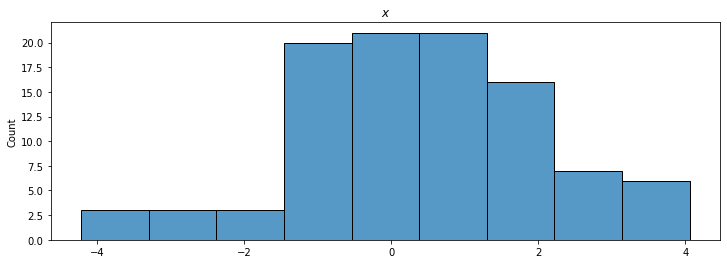

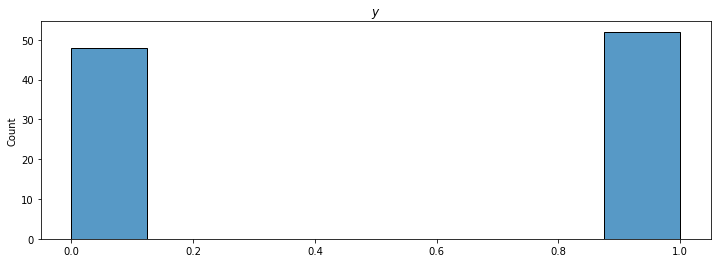

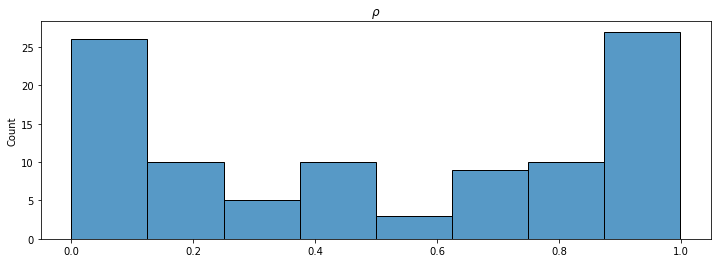

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
sns.histplot(x, ax=ax)
ax.set_title('$x$')
plt.show()

fig, ax = plt.subplots(figsize=(12,4))
sns.histplot(y, ax=ax)
ax.set_title('$y$')
plt.show()

fig, ax = plt.subplots(figsize=(12,4))
sns.histplot(r, ax=ax)
ax.set_title('$\\rho$')
plt.show()

# Implement AUC

In [ ]:
def order(x1, x2):
  if x1 > x2:
    return 1
  if x1 == x2:
    return 0.5
  return 0

def auc_naive(x, r):
  assert(x.shape == r.shape)
  N = len(x)

  expected_num_one = np.sum(r)
  expected_num_zero = np.sum(1 - r)

  expected_pairs_correct = 0
  for i in range(N):
    for j in range(N):
      ord = order(x[i], x[j])
      expected_pairs_correct += ord * r[i] * (1 - r[j])

  return expected_pairs_correct / (expected_num_one * expected_num_zero)

In [ ]:
# Can't handle ties
def auc_efficient_simplistic(x, r):
  assert(x.shape == r.shape)
  N = len(x)

  idx = np.argsort(x)
  x = x[idx]
  r = r[idx]

  expected_num_one = np.sum(r)
  expected_num_zero = np.sum(1 - r)

  expected_pairs_correct = 0
  zeros_below = 0
  for i in range(N):
    expected_pairs_correct += r[i] * (zeros_below + 0.5 * (1 - r[i]))
    zeros_below += (1 - r[i])

  return expected_pairs_correct / (expected_num_one * expected_num_zero)

In [ ]:
def auc_efficient(x, r):
  assert(x.shape == r.shape)
  N = len(x)

  idx = np.argsort(x)
  x = x[idx]
  r = r[idx]

  expected_num_one = np.sum(r)
  expected_num_zero = np.sum(1 - r)

  expected_pairs_correct = 0
  zeros_below_lower = 0
  lower = 0
  upper = 0
  stretch = deque()

  for i in range(N):
    while (upper < N) and (x[upper] <= x[i]):
      stretch.append(1 - r[upper])
      upper += 1
    while x[lower] < x[i]:
      lower += 1
      zeros_below_lower += stretch.popleft()

    expected_pairs_correct += r[i] * (zeros_below_lower + 0.5 * np.sum(stretch))

  return expected_pairs_correct / (expected_num_one * expected_num_zero)

In [ ]:
# Really simple data for debugging/step-through.
x_test = np.array([1, 2, 2, 3, 3, 3, 4, 5])
r_test = np.array([0.15, 0.21, 0.19, 0.33, 0.27, 0.32, 0.41, 0.56])

print('{:.5f}'.format(auc_naive(x_test, r_test)))
print('{:.5f}'.format(auc_efficient_simplistic(x_test, r_test))) # incorrect because of ties
print('{:.5f}'.format(auc_efficient(x_test, r_test)))

0.65627
0.65479
0.65627


In [ ]:
# "Real" data
print('{:.5f}'.format(auc_naive(x, r)))
print('{:.5f}'.format(auc_efficient_simplistic(x, r))) # incorrect because of ties
print('{:.5f}'.format(auc_efficient(x, r)))

0.66532
0.66562
0.66532


# Range

It's worth noting that when the labels are uncertain, it is not possible to achieve an AUC of 1.0. Even if we could perfectly predict $\rho$, the inherent randomness in $y$ ensures that we can never perfectly order the data.

We can compute the maximum possible value by plugging in $\pi^{(i)}=\rho^{(i)}$ in the formula.

In [ ]:
print('{:.5f}'.format(auc_efficient(r, r)))

0.93071


This maximum value depends on the distribution of the $\rho$ values. Let's look at a really simple example, where this distribution is uniform. In this case we can find the limiting value analytically.

In the limit as $N$ becomes large, the three components of the AUC will all limit to their expected values, which we can compute separately.

For the numerator,

$
\begin{align}
\mathbb{E}\left[ \sum_i \sum_j \text{order}(\rho^{(i)}, \rho^{(j)}) \rho^{(i)} (1-\rho^{(j)}) \right]
&\approx N^2 \mathbb{E}\left[ \text{order}(\hat{\rho}, \check{\rho}) \hat{\rho} (1-\check{\rho}) \right] & \text{ignoring the $i=j$ case} \\
&= N^2 \int_0^1 \int_0^1 \text{order}(\hat{\rho}, \check{\rho}) \hat{\rho} (1-\check{\rho}) p(\hat{\rho}) p(\check{\rho}) d\hat{\rho} d\check{\rho} & \text{definition of expectation} \\
&= N^2 \int_0^1 \hat{\rho} p(\hat{\rho}) \left[ \int_0^1 \text{order}(\hat{\rho}, \check{\rho})  (1-\check{\rho})  p(\check{\rho}) d\check{\rho} \right] d\hat{\rho} & \text{pulling terms out of inner integral} \\
&= N^2 \int_0^1 \hat{\rho} \left[ \int_0^\hat{p} (1-\check{\rho}) d\check{\rho} \right] d\hat{\rho} & \text{definition of order, uniform density} \\
&= N^2 \int_0^1 \hat{\rho} \left[ \hat{p} - \frac{\hat{p}^2}{2} \right] d\hat{\rho} & \text{evaluate inner integral} \\
&= N^2 \cdot \frac{5}{24} & \text{evaluate outer integral}
\end{align}
$

For the denominator terms,

$
\begin{align}
\mathbb{E}\left[\sum_i \rho^{(i)}\right] = \mathbb{E}\left[\sum_j (1 - \rho^{(j)})\right] = \frac{N}{2}
\end{align}
$

Plugging these in, we have

$
\begin{align}
p(\omega=1 | \hat{y}=1, \check{y}=0) \approx \frac{N^2 \cdot \frac{5}{24}}{\frac{N}{2} \cdot \frac{N}{2}} = \frac{5}{6} \approx 0.833
\end{align}
$

We can check this by simulation.

In [ ]:
unif_preds = stats.uniform.rvs(size=10000)
print('{:.3f}'.format(auc_efficient(unif_preds, unif_preds)))

0.835


Well that was fun. Let's do another. This time suppose that predictions are evenly distributed between 3 values: $0$, $1$ and $\frac{1}{2}$.

There are 9 possible input combinations for the $\text{order}(\rho^{(i)}, \rho^{(j)})$ term,

$
\begin{align}
\text{order}(0,1) = \text{order}(0,\frac{1}{2}) = \text{order}(\frac{1}{2},1) = 0 \\
\text{order}(1,0) = \text{order}(\frac{1}{2},0) = \text{order}(1,\frac{1}{2}) = 1 \\
\text{order}(0,0) = \text{order}(\frac{1}{2},\frac{1}{2}) = \text{order}(1,1) = \frac{1}{2}
\end{align}
$

For the $\rho^{(i)} (1 - \rho^{(j)})$ term, 5 of the 9 combinations are 0 because either $\rho^{(i)}=0$ or $\rho^{(j)}=1$ (or both). This leaves us with $(1,0)$, $(1,\frac{1}{2})$, $(\frac{1}{2}, 0)$, $(\frac{1}{2}, \frac{1}{2})$

Putting this together,

$
\begin{align}
\mathbb{E}\left[ \sum_i \sum_j \text{order}(\rho^{(i)}, \rho^{(j)}) \rho^{(i)} (1-\rho^{(j)}) \right]
&\approx N^2 \mathbb{E}\left[ \text{order}(\hat{\rho}, \check{\rho}) \hat{\rho} (1-\check{\rho}) \right] & \text{ignoring the $i=j$ case} \\
&= N^2 \left[ 1 \cdot 1 \cdot \frac{1}{9} + 1 \cdot \frac{1}{2} \cdot \frac{1}{9}  + 1 \cdot \frac{1}{2} \cdot \frac{1}{9} + \frac{1}{2} \cdot \frac{1}{4} \cdot \frac{1}{9} \right] & \text{evaluate the expectation} \\
&= N^2 \frac{17}{72}
\end{align}
$

Plugging these in, we have

$
\begin{align}
p(\omega=1 | \hat{y}=1, \check{y}=0) \approx \frac{N^2 \cdot \frac{17}{72}}{\frac{N}{2} \cdot \frac{N}{2}} = \frac{17}{18} \approx 0.944
\end{align}
$


In [ ]:
ternary_preds = np.concatenate((np.zeros(1000), 0.5*np.ones(1000), np.ones(1000)))
print('{:.3f}'.format(auc_efficient(ternary_preds, ternary_preds)))

0.944


# Testing

In [ ]:
# Really simple data for debugging/step-through.
x_test = np.array([0.8, 0.3])
r_test = np.array([1.0, 0.2])

print('{:.5f}'.format(1.0 - auc_naive(x_test, r_test)))
print('{:.5f}'.format(1.0 - auc_efficient(x_test, r_test)))

0.08333
0.08333
